<a href="https://colab.research.google.com/github/geekpradd/Reinforcement-Learning-Stock-Trader/blob/master/New_Stock_Updated1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [581]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from tensorflow.keras.layers import Dense, Concatenate, Lambda, Activation
from tensorflow.keras import Input
from tensorflow import convert_to_tensor as convert
import pickle
# COLAB = False
# if not COLAB:
#     import os
#     os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
path_base = ''
import os

In [582]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        
        self.num_stocks = params['num_stocks']
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.balance_normal = params['balance_normal']
        self.shares_normal = params['shares_normal']
        self.volume_normal = params['volume_normal']
        self.dfs = df
        self.state_dimensions = self.num_stocks*5+1
        self.train = train

        assert len(df) == self.num_stocks, "Size of database not equal to number of stocks"

        self.max_steps = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = -1, high = 1, shape =  (1, self.num_stocks*2), dtype = np.float32)
        self.observation_space = spaces.Box(low = 0, high = 1, shape = (1, self.state_dimensions), dtype = np.float32)

    def reset(self, intial_balance = 10000, shares_held = None):

        if self.train:
            self.current_step = np.random.randint(0, self.max_steps)
        else:
            self.current_step = 0
        print('current_step',self.current_step)
        self.balance = intial_balance
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = np.zeros((1, self.num_stocks))
        self.current_price = self.get_price()
        self.highest_price = 0
        self.net_worth = self.balance + np.sum(self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.set_high()
        self.done = False
        self.frame = np.zeros((1, self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance,
        }
        return self.observe()
        
    def get_price(self):
#         for df in self.dfs:
#             #print(self.current_step, [df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]])
        return np.array([np.random.uniform(df.loc[self.current_step,"Low"], df.loc[self.current_step,"High"]) for df in self.dfs]).reshape((1, self.num_stocks))
      
    def set_high(self):
        high = np.array([df.loc[self.current_step, 'High'] for df in self.dfs]).reshape((1, self.num_stocks))
        self.highest_price = np.maximum(self.highest_price, high)
        for i in range(self.highest_price.shape[1]):
            if not np.isfinite(self.highest_price[0][i]):
                self.highest_price[0][i]=1

    def observe(self):
        for i in range(self.num_stocks):
            self.frame[0, 4*i:4*i+4] = np.array([self.dfs[i].loc[self.current_step,'Open'],self.dfs[i].loc[self.current_step,'High'],self.dfs[i].loc[self.current_step,'Low'],self.dfs[i].loc[self.current_step,'Close']])/self.highest_price[0, i]
        self.frame[0, self.num_stocks*4:self.num_stocks*5] = self.shares_held/self.shares_normal
        self.frame[0, 5*self.num_stocks] = self.balance/self.balance_normal
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'shares_normal' : self.shares_normal,
            'balance_normal' : self.balance_normal,
            'balance' : self.balance
        }
        return self.frame, self.info
    
    def update_worth(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def update_balance(self, action):
        self.balance += np.sum(action[:, :self.num_stocks]*self.current_price)
        self.balance -= np.sum(action[:, self.num_stocks:]*self.current_price)

    def update_shares(self, action):
        self.shares_held -= action[:, :self.num_stocks]
        self.shares_held +=  action[:, self.num_stocks:]

    def take_action(self, action):
        self.current_price = self.get_price()
        action[:, :self.num_stocks] = np.floor(action[:, :self.num_stocks] *self.shares_held)
        if not np.isfinite(self.current_price).all():
            print('gadbad in current price')
            self.current_price=np.ones(self.current_price.shape)
        action[:, self.num_stocks:] = np.floor(action[:, self.num_stocks:] * self.balance / self.current_price)
        self.set_high()
        self.update_balance(action)
        self.update_shares(action)
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.update_worth(reward)
        return reward
            
    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros((1, self.state_dimensions)), 0, self.done, self.info
        if np.sum(action[:, self.num_stocks:]) > 1:
            print('gadbad')
        reward = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.05
        if self.done:
            print('snap')
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(locations, train=True):
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
    params = {
        'num_stocks' : len(locations),
        'min_brokerage' : 30.0,
        'brokerage_rate' : 0.001,
        'balance_normal' : 1000000,
        'shares_normal' : 10000,
        'volume_normal' : 2147483647,
    }
    return StockEnv(dfs, params, train)

In [583]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.size = buffer_size
        self.buffer = deque()
        
    def add(self, data_tuple):
        self.buffer.append(data_tuple)
        if len(self.buffer) > self.size:
            self.buffer.popleft()
            
    def sample(self, sample_size):
        size = min(len(self.buffer), sample_size)
        return random.sample(self.buffer, size), size
        
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [584]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.cap = params['cap']
        self.actor = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=(self.state_dimensions, ))
        x = Dense(1024, activation = 'relu')(inputs)
        x = Dense(256, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        sell = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        buy = Dense(self.action_dimensions, activation = 'sigmoid')(x)
        final_buy = Activation(tf.keras.activations.softmax)(buy)*tf.math.minimum(self.cap, tf.reduce_sum(buy, axis = -1, keepdims = True))
        model = keras.Model(inputs = inputs, outputs = tf.concat([sell, final_buy], axis = -1))
        # model.summary()
        return model
    
    def get_action(self, state):
        return self.actor(convert(state))

    def save(self):
        self.actor.save(path_base + 'actor.h5')
    
    def load(self):
        self.actor = keras.models.load_model(path_base + 'actor.h5')
        print('Successfully Loaded')

class Critic:
    def __init__(self, params):
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.tau = params['tau']
        self.critic_online = self.build_model()
        self.critic_target = self.build_model()
        self.critic_online.set_weights(self.critic_target.get_weights())

    def build_model(self):
        input_a = Input(shape = (self.state_dimensions, ))
        input_b = Input(shape = (2*self.action_dimensions, ))
        input = Concatenate(axis = -1)([input_a, input_b])
        x = Dense(1024, activation = 'relu')(input)
        x = Dense(256, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        output = Dense(1)(x)
        model = keras.Model(inputs=[input_a, input_b], outputs = output)
        model.compile(loss='mse', optimizer = keras.optimizers.Adam(learning_rate = 0.001))
        # model.summary()
        return model

    def save(self):
        self.critic_online.save(path_base + 'critic_online.h5')
        self.critic_target.save(path_base + 'critic_target.h5')

    def load(self):
        self.critic_online = keras.models.load_model(path_base + 'critic_online.h5')
        self.critic_target = keras.models.load_model(path_base + 'critic_target.h5')

    def get_qvalues(self, state_array, action_array, online=True):
        if online:
            return self.critic_online([convert(state_array), convert(action_array)])
        else:
            return self.critic_target([convert(state_array), convert(action_array)])

    def call(self, state_tensor, action_tensor):
        return self.critic_online([state_tensor, action_tensor])
    
    def merge(self):
        self.critic_target.set_weights(self.tau*np.array(self.critic_online.get_weights())
                                                                    + (1-self.tau)*np.array(self.critic_target.get_weights()))

In [585]:
class Agent:
    def __init__(self, params, train = True, resume = True):
        self.back_state = 20
        self.train = train
        params["state_dimensions"]=params['state']*self.back_state
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayMemory(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.cap = params['cap']
        self.num_steps = 0
        self.state = np.zeros((self.back_state,self.state_dimensions//self.back_state))
        self.have_state = 1
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(2*params["action_dimensions"]))
        if resume:
            self.load()
    def agent_start(self):
        self.state = np.zeros((self.back_state,self.state_dimensions//self.back_state))
        self.have_state=1
#         if self.train:
#             action = self.clip_action(action + self.noise_func())
#         else:
#             action = self.clip_action(action)

    def clip_action(self, action):
        action = np.clip(action, 0, self.action_range)
        sum = np.sum(action, axis = -1, keepdims = True)
        if sum==0:
            return action
        action = action*np.minimum(sum, self.cap)/sum
        return action

    def agent_step(self, reward, observation):
#         print(self.state)
#         print(self.state.shape)
        if self.have_state < self.back_state:
            action = np.zeros((1,self.action_dimensions*2))
            self.state[self.have_state-1] = observation
            self.have_state += 1
            self.prev_action = action
            self.prev_state = np.reshape(self.state, [1,self.state_dimensions])
            return self.prev_action
        if self.have_state == self.back_state:
            self.state[-1] = observation
            #print(self.state)
            action = self.actor.get_action(np.reshape(self.state, [1,self.state_dimensions]))
            if self.train:
                action = self.clip_action(action + self.noise_func())
            else:
                action = self.clip_action(action)
            self.prev_state = np.reshape(self.state, [1,self.state_dimensions])
            self.prev_action = action
            self.have_state+=1
            return self.prev_action
        
#         print(self.state.shape)
        self.state = self.state[1:,:]
        self.state = np.append(self.state,observation,axis=0)
#         print(self.state)
#         print(self.state.shape)
        state = np.reshape(self.state, [1,self.state_dimensions])
        if self.train:
            replay = (self.prev_state, self.prev_action, reward, state)
            self.buffer.append(replay)
            
        action = self.actor.get_action(state)
        if self.train:
            action = self.clip_action(action + self.noise_func())
            self.run()
        else:
            action = self.clip_action(action)
        self.prev_action = action
        self.prev_state = state
        return self.prev_action 
    
    def save(self):
        print('saving')
        self.actor.save()
        self.critic.save()
        data = (self.buffer, self.num_steps, self.noise_func)
        with open (path_base + 'auxiliary.pkl', 'wb') as f:
            pickle.dump(data, f)

    def load(self):
        print('loading')
        self.actor.load()
        self.critic.load()
        with open (path_base + 'auxiliary.pkl', 'rb') as f:
            data = pickle.load(f)
        self.buffer, self.num_steps, self.noise_func = data
    
    def run(self):
        self.num_steps += 1
        size = min(self.batch_size, self.buffer.size)
        batch = self.buffer.sample(size)

        prev_states = np.array([x[0] for x in batch]).reshape((-1, self.state_dimensions))
        prev_actions = np.array([x[1] for x in batch]).reshape((-1, 2*self.action_dimensions))
        rewards = np.array([x[2] for x in batch]).reshape((-1, 1))
        states = np.array([x[3] for x in batch]).reshape((-1, self.state_dimensions))
        actions = self.actor.get_action(states)
        q_values = self.critic.get_qvalues(states, actions, False)
        q_values += self.discount*rewards
        self.critic.critic_online.fit([states, actions], q_values, epochs = 1, verbose=0)

        prev_state_tensor = convert(prev_states)
        prev_action_tensor = convert(prev_actions)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(prev_action_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.actor(prev_state_tensor)
        gradient = -tape.gradient(value, prev_action_tensor)
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = tape.gradient(action, self.actor.actor.trainable_weights, gradient)
        gradient_actor = list(np.array(gradient_actor)/size)

        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))
        self.critic.merge()

        if self.num_steps % self.save_frequency == 0:
            self.save()

In [677]:
epochs_per_iter = 50

def train(agent, env, epochs, profits, balances, shares, actions):

    steps_per_epoch = 2000
    
    for epoch in range(epochs, epochs + epochs_per_iter+1):

        cumm_profit = 0
        observation, info = env.reset()
        shares[epoch, 0, :] = info['shares_held']
        balances[epoch, 0] = info['balance']
        agent.agent_start()
        action = agent.agent_step(0,observation)
        actions[epoch, 0, :] = action

        for i in tqdm(range(steps_per_epoch)):

            observation, reward, done, info = env.step(action)
            shares[epoch, i+1, :] = info['shares_held']
            balances[epoch, i+1] = info['balance']
            cumm_profit += reward
            profits[epoch, i] = cumm_profit
            if done:
                break
            action = agent.agent_step(reward, observation)
#             if i%400==0:
#                 print(i,action)
            if not np.isfinite(action).all():
                for att in vars(agent):
                    print (att, getattr(agent,att))
                print('--------------------------------------------------------------------------------------------------')
                for att in vars(agent.actor):
                    print (att, getattr(agent.actor,att))
                print('--------------------------------------------------------------------------------------------------')
                # print(--------------------------------------------------------------------------------------------------------)
                for att in vars(agent.critic):
                    print (att, getattr(agent.critic,att)) 
                print('--------------------------------------------------------------------------------------------------')
                #print(--------------------------------------------------------------------------------------------------------)
                for att in vars(env):
                    print (att, getattr(env,att))
                print('--------------------------------------------------------------------------------------------------')
                #     print(--------------------------------------------------------------------------------------------------------)
                break
                for name, value in globals().items():
                     print(name, value)
            actions[epoch, i+1, :] = action
#         print(action)
        print('Completed epoch' + str(epoch),profits[epoch,i])

        if epoch % 10 == 0:
            data = epoch, profits, shares, balances, actions
            with open(path_base + 'graph.pkl', 'wb') as f:
                pickle.dump(data, f)

In [678]:
AGENT_PARAMS = {
	"output_range": 1,
	"state": 11,
	"action_dimensions": 2,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0001),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.00005),
	"batch_size": 64,
	"buffer_size":100000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 5000,
	'cap' : 0.9,
}

In [679]:
stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
files = ['M.csv','PCG.csv']
env = create_stock_env(files,train= True)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS, train = True,resume = True)

loading
Successfully Loaded


In [680]:
steps_per_epoch = 2000
print(agent.num_steps)
#stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
#while epochs<600:
data = [0,np.zeros((50*epochs_per_iter,steps_per_epoch)),np.zeros((50*epochs_per_iter,steps_per_epoch+1,2)),np.zeros((50*epochs_per_iter,1+steps_per_epoch)),np.zeros((50*epochs_per_iter,1+steps_per_epoch,4))]    
for f in stocks:
    with open(path_base + 'graph.pkl', 'rb') as fi:
        data = pickle.load(fi)
    files = ['AAPL.csv',f]
    print(files)
    env = create_stock_env(files,train= True)
    epochs, profits, shares, balances, actions = data
    train(agent, env, epochs, profits, balances, shares, actions)
    epochs+=epochs_per_iter
    for i in range(25):
        os.system("printf '\a'")

  0%|          | 0/2000 [00:00<?, ?it/s]

945000
['AAPL.csv', 'IBM.csv']
current_step 3830


100%|██████████| 2000/2000 [01:27<00:00, 22.78it/s]


Completed epoch0 15025.015979878252


  1%|          | 21/2000 [00:00<00:09, 203.95it/s]

current_step 3252


  1%|          | 22/2000 [00:00<00:12, 156.26it/s]

Completed epoch1 10465.741554105174
current_step 698


 53%|█████▎    | 1056/2000 [00:47<00:43, 21.81it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 157.55it/s]

Completed epoch2 14640.36698797789
current_step 7759


  1%|          | 21/2000 [00:00<00:09, 203.75it/s]

Completed epoch3 17373.3623438336
current_step 3994


  1%|          | 22/2000 [00:00<00:12, 154.82it/s]

Completed epoch4 22657.028954995338
current_step 7087


  6%|▌         | 111/2000 [00:04<01:27, 21.65it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 153.17it/s]

Completed epoch5 16872.810776084978
current_step 544


  1%|          | 21/2000 [00:00<00:09, 201.10it/s]

Completed epoch6 35830.75982403771
current_step 7716


 57%|█████▊    | 1150/2000 [00:51<00:38, 21.85it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 154.70it/s]

Completed epoch7 14170.210435088633
current_step 7952


  1%|          | 21/2000 [00:00<00:09, 201.78it/s]

Completed epoch8 17923.553902113825
current_step 1037


  1%|          | 22/2000 [00:00<00:12, 155.01it/s]

Completed epoch9 9240.033743590597
current_step 6953


 10%|█         | 207/2000 [00:08<01:22, 21.62it/s]

saving


100%|██████████| 2000/2000 [01:32<00:00, 21.56it/s]


Completed epoch10 16188.004914437497


  1%|          | 21/2000 [00:00<00:10, 186.80it/s]

current_step 1546


  1%|          | 21/2000 [00:00<00:09, 204.80it/s]

Completed epoch11 1716.6059638859442
current_step 289


 62%|██████▏   | 1246/2000 [00:56<00:34, 21.84it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 152.93it/s]

Completed epoch12 27343.99046010701
current_step 9722


  1%|          | 22/2000 [00:00<00:12, 157.52it/s]

Completed epoch13 488.9193631418839
current_step 9443


  1%|          | 22/2000 [00:00<00:13, 147.81it/s]

Completed epoch14 -428.1480817894717
current_step 1548


  1%|          | 22/2000 [00:00<00:12, 158.36it/s]

Completed epoch15 1438.6203252334617
current_step 9783


  1%|          | 22/2000 [00:00<00:12, 153.80it/s]

Completed epoch16 1632.4561566293214
current_step 1726


 70%|██████▉   | 1398/2000 [01:03<00:27, 22.01it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 154.11it/s]

Completed epoch17 2445.3677977767074
current_step 8679


  1%|          | 22/2000 [00:00<00:12, 154.83it/s]

Completed epoch18 31919.14290571533
current_step 1051


  1%|          | 22/2000 [00:00<00:12, 158.16it/s]

Completed epoch19 16189.12507665839
current_step 2437


 59%|█████▊    | 1173/2000 [00:53<00:37, 21.84it/s]

saving


100%|██████████| 2000/2000 [01:32<00:00, 21.67it/s]


Completed epoch20 1879.1002400135876


  1%|          | 21/2000 [00:00<00:10, 196.24it/s]

current_step 1675


  1%|          | 22/2000 [00:00<00:12, 156.00it/s]

Completed epoch21 1005.9398009948236
current_step 934


  1%|          | 21/2000 [00:00<00:09, 200.19it/s]

Completed epoch22 1539.4417152860242
current_step 1054


 11%|█▏        | 229/2000 [00:09<01:21, 21.72it/s]

saving


  1%|          | 22/2000 [00:00<00:13, 148.95it/s]

Completed epoch23 15656.403305096464
current_step 5585


  1%|          | 22/2000 [00:00<00:12, 153.83it/s]

Completed epoch24 32844.19375935963
current_step 2097


 63%|██████▎   | 1266/2000 [00:57<00:34, 21.56it/s]

saving


  1%|          | 21/2000 [00:00<00:09, 202.63it/s]

Completed epoch25 -1548.9298930727873
current_step 4860


  1%|          | 22/2000 [00:00<00:12, 157.89it/s]

Completed epoch26 11684.525397906327
current_step 5935


  1%|          | 22/2000 [00:00<00:12, 155.91it/s]

Completed epoch27 23028.173399577667
current_step 9608


 16%|█▌        | 324/2000 [00:13<01:17, 21.70it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 156.89it/s]

Completed epoch28 2702.8460016935605
current_step 1951


  1%|          | 21/2000 [00:00<00:09, 204.19it/s]

Completed epoch29 -1657.0523451004083
current_step 8688


 64%|██████▍   | 1275/2000 [00:57<00:32, 22.29it/s]


Completed epoch30 6453.4760863242045


  1%|          | 21/2000 [00:00<00:10, 187.77it/s]

current_step 5572


 88%|████████▊ | 1751/2000 [01:18<00:11, 22.06it/s]

saving


  1%|          | 22/2000 [00:00<00:12, 158.18it/s]

Completed epoch31 32535.043921669727
current_step 9651


  1%|          | 22/2000 [00:00<00:12, 153.70it/s]

Completed epoch32 3328.648952862495
current_step 852


  1%|          | 21/2000 [00:00<00:09, 202.75it/s]

Completed epoch33 9347.209777534586
current_step 625


  1%|          | 22/2000 [00:00<00:12, 159.27it/s]

Completed epoch34 -137.30071053965366
current_step 2635


 26%|██▌       | 515/2000 [00:23<01:14, 19.89it/s]

saving


  1%|          | 22/2000 [00:00<00:13, 151.41it/s]

Completed epoch35 175.11963695033228
current_step 219


  1%|          | 21/2000 [00:00<00:09, 203.40it/s]

Completed epoch36 18096.629772235967
current_step 1226


 78%|███████▊  | 1554/2000 [01:12<00:22, 19.83it/s]

saving


  1%|          | 21/2000 [00:00<00:09, 198.35it/s]

Completed epoch37 -1461.4997335518528
current_step 6370


  1%|          | 22/2000 [00:00<00:12, 156.63it/s]

Completed epoch38 58873.088219786034
current_step 4398


  1%|          | 21/2000 [00:00<00:09, 202.45it/s]

Completed epoch39 51630.43584241752
current_step 510


 13%|█▎        | 253/2000 [00:10<01:15, 23.24it/s]


KeyboardInterrupt: 

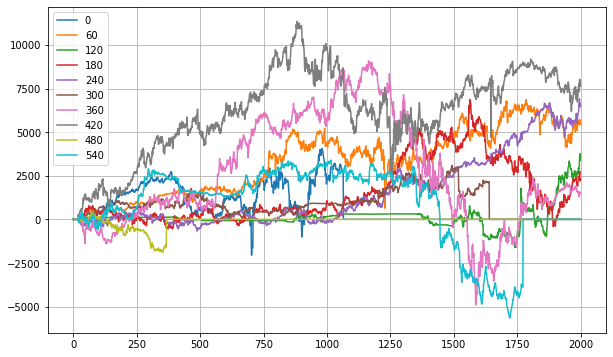

In [439]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs,epochs//10):
    plt.plot(profits[i])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

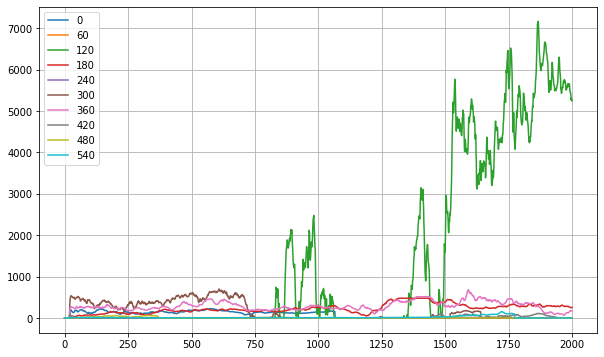

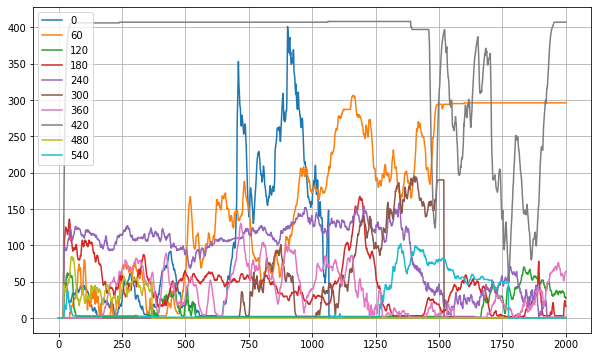

In [440]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(shares[i, :, 0])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(shares[i, :, 1])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

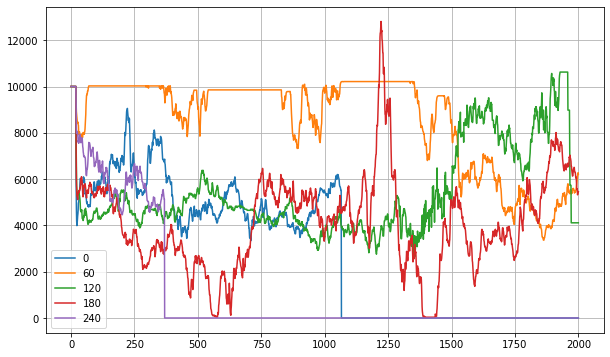

In [441]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//5):
    plt.plot(balances[i])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

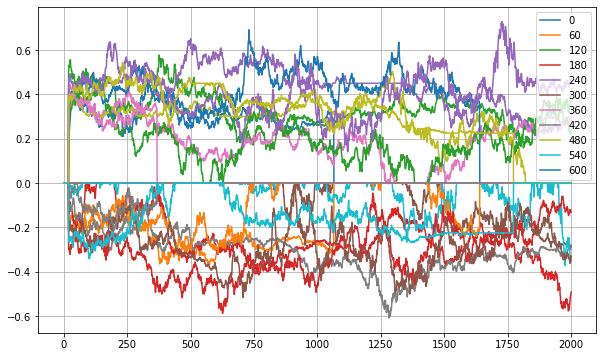

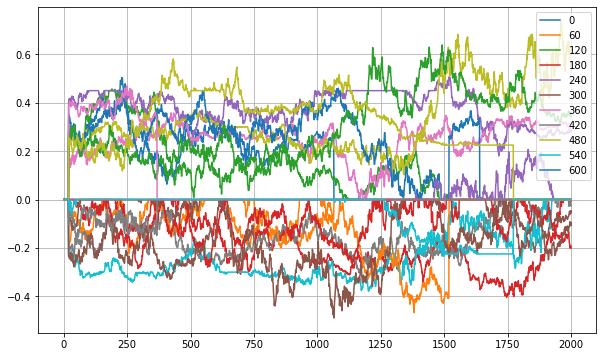

In [442]:
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(actions[i, :, 0])
    plt.plot(-actions[i,:, 2])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()
plt.figure(figsize = [10, 6])
for i in range(0, epochs, epochs//10):
    plt.plot(actions[i, :, 1])
    plt.plot(-actions[i,:, 3])
plt.legend(list(range(0, epochs+50,epochs//10)))
plt.grid()
plt.show()

In [667]:
files = np.random.choice(stocks,2)
print(files)
files = ['AAPL.csv','PCG.csv']
def test(env):
    agent = Agent(AGENT_PARAMS, train = False, resume = True)
    print(agent.num_steps)
    max_steps = env.max_steps
    profitst = np.zeros(max_steps)
    balancest = np.zeros( max_steps + 1)
    sharest = np.zeros((max_steps+1, agent.action_dimensions))
    actionst = np.zeros((max_steps+1, agent.action_dimensions*2))

    for count, val in enumerate(values):
        profit = 0
        observation, info = env.reset(intial_balance = 20000)
        balancest[0] = info['balance']
#         print(info['balance'])
        sharest[0] = info['shares_held']
#         print(info['shares_held'])
        agent.agent_start()
        action = agent.agent_step(0,observation)
        actionst[0] = action

        for i in tqdm(range(6000)):
            observation, reward, done, info = env.step(action)
            profit += reward
            profitst[i] = env.net_worth
            balancest[i+1] = info['balance']
            sharest[i+1] = info['shares_held']
            #print(action)
            #print('state',agent.state)
            if done:
                break
            action = agent.agent_step(reward, observation)
            actionst[i+1] = action
#             print('o',action)
        print(profitst[i-1])
        print('Completed' + str(count) + 'values')

    return profitst, balancest, sharest, actionst


['RELIN.csv' 'DXC.csv']


['BPCL.csv' 'BPCL.csv']
loading
Successfully Loaded


  1%|          | 53/6000 [00:00<00:11, 520.74it/s]

945000
current_step 0


 43%|████▎     | 2571/6000 [00:06<00:08, 397.30it/s]


45755.09057293326
Completed0values


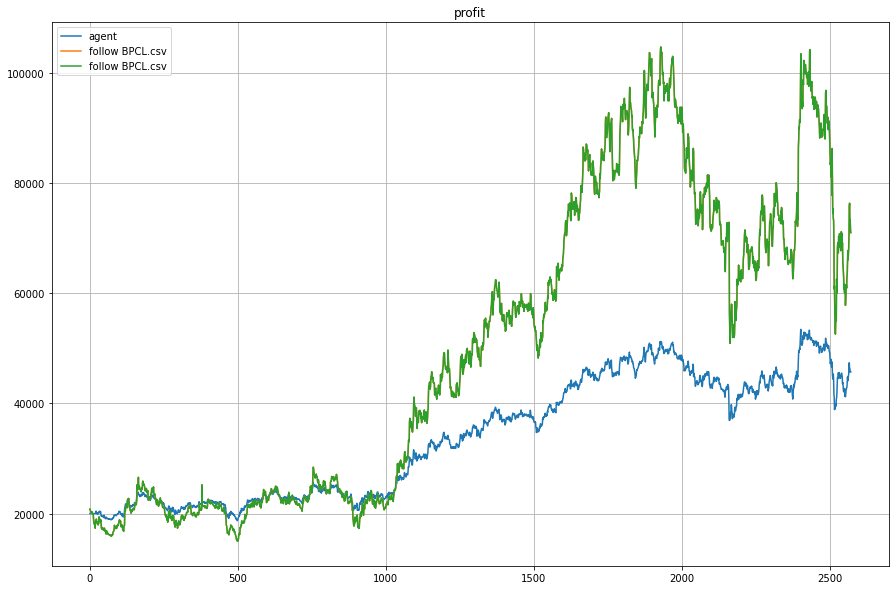

In [674]:
#stocks = ['IBM.csv','GOOG.csv', 'AAPL.csv', 'MSFT.csv','AMZN.csv','DXC.csv','INFY.csv','M.csv','PCG.csv', 'PNB.csv', 'RELIN.csv','BPCL.csv']
files = np.random.choice(stocks,2)
files[0] = files[1]
print(files)
env = create_stock_env(files, train = False)
profitst, balancest, sharest, actionst = test(env)

df1 = pd.read_csv(files[0])
df2 = pd.read_csv(files[1])
plt.figure(figsize = [15, 10])
plt.plot(profitst[:])
plt.plot(df1.loc[:6000,'High']*20000/df1.loc[0,'Low'])
plt.plot(df2.loc[:6000,'High']*20000/df2.loc[0,'Low'])
plt.legend(['agent','follow '+files[0],'follow '+files[1]])
plt.grid()
plt.title('profit')
plt.show()

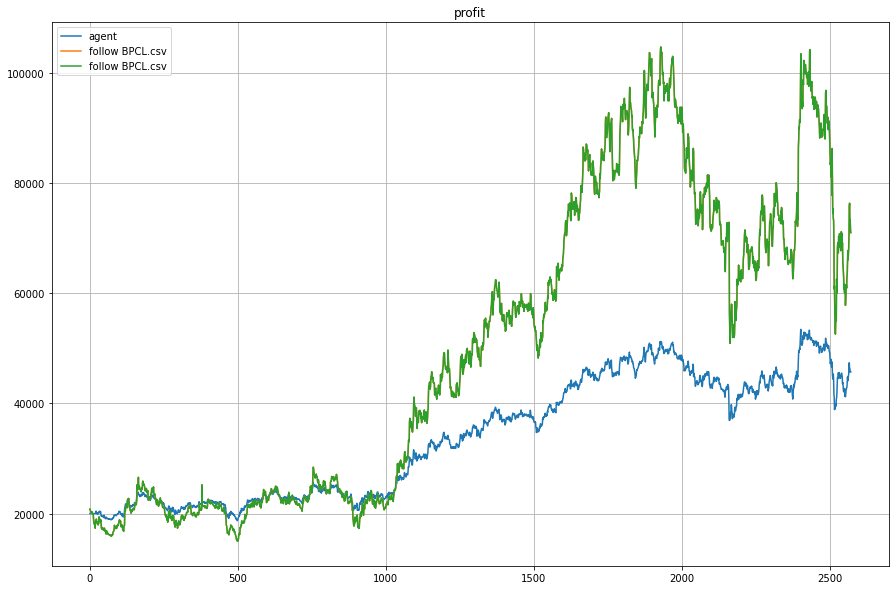

In [676]:
df1 = pd.read_csv(files[0])
df2 = pd.read_csv(files[1])
plt.figure(figsize = [15, 10])
plt.plot(profitst[:])
plt.plot(df1.loc[:env.max_steps,'High']*20000/df1.loc[0,'Low'])
plt.plot(df2.loc[:env.max_steps,'High']*20000/df2.loc[0,'Low'])
plt.legend(['agent','follow '+files[0],'follow '+files[1]])
plt.grid()
plt.title('profit')
plt.show()

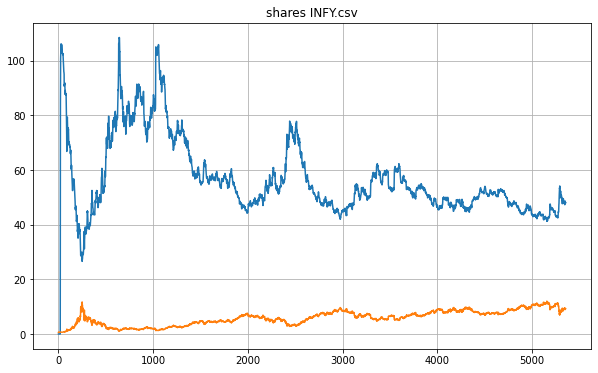

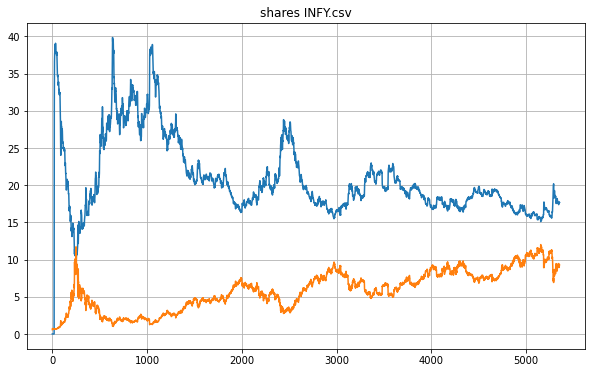

In [661]:
for count,i in enumerate(files):
    plt.figure(figsize = [10, 6])
    plt.plot(sharest[:, count]*0.01)
    df = pd.read_csv(i)
    plt.plot(df['Open'])
    plt.grid()
    plt.title('shares '+i)
    plt.show()

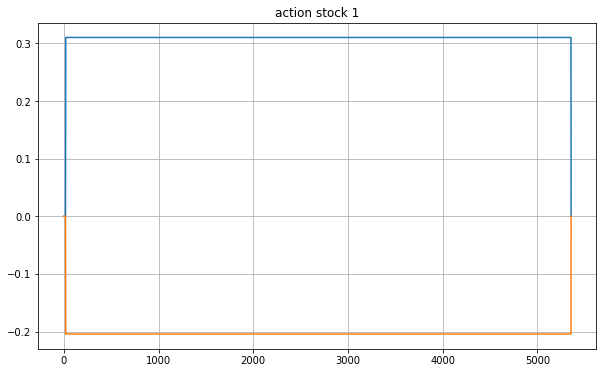

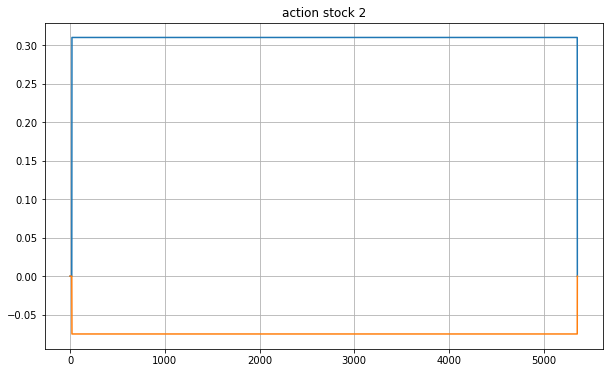

In [663]:
plt.figure(figsize = [10, 6])
plt.plot(actionst[:,0])
plt.plot(-actionst[:,2])
plt.grid()
plt.title('action stock 1')
plt.show()
    
plt.figure(figsize = [10, 6])
plt.plot(actionst[:,1])
plt.plot(-actionst[:,3])
plt.grid()
plt.title('action stock 2')
plt.show()

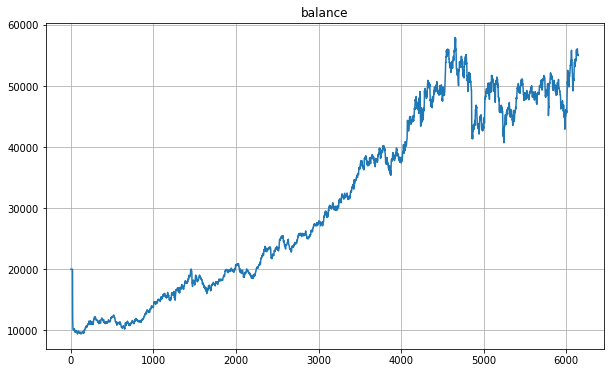

In [610]:
plt.figure(figsize = [10, 6])
plt.plot(balancest[:])
plt.grid()
plt.title('balance')
plt.show()

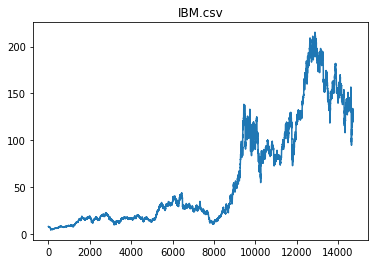

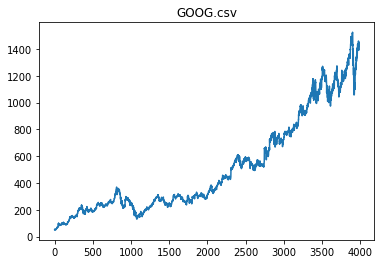

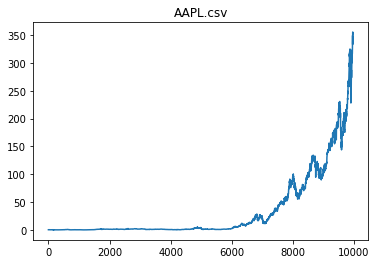

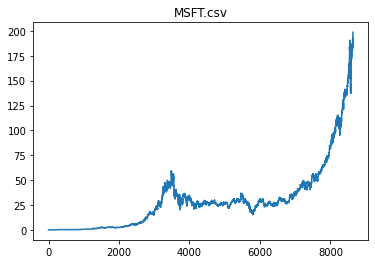

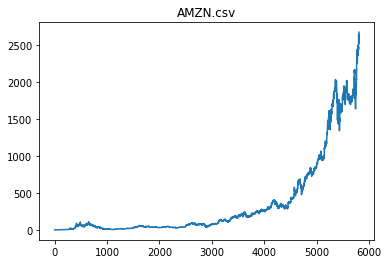

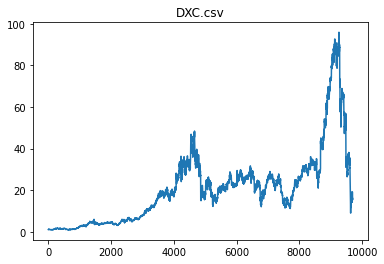

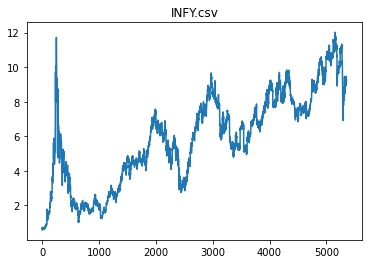

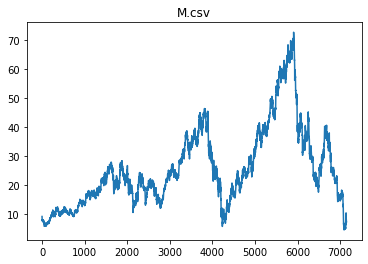

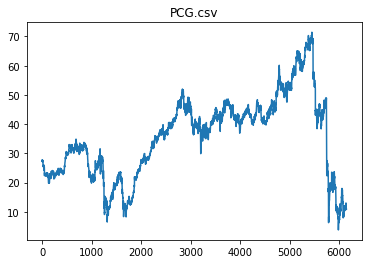

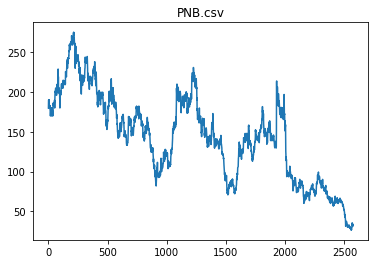

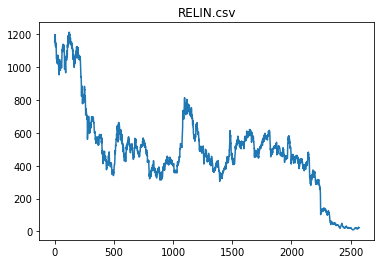

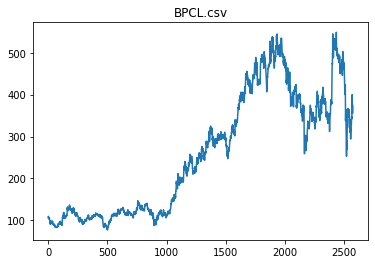

In [477]:
for i in stocks:
    df = pd.read_csv(i)
    plt.plot(df['Open'])
    plt.title(i)
    plt.show()

    
#dxc,m,pcg   
#IBM
#infy
#google,aapl,msft,amzn

In [188]:
for att in vars(agent):
    print (att, getattr(agent,att))
print('--------------------------------------------------------------------------------------------------')
for att in vars(agent.actor):
    print (att, getattr(agent.actor,att))
print('--------------------------------------------------------------------------------------------------')
# print(--------------------------------------------------------------------------------------------------------)
for att in vars(agent.critic):
    print (att, getattr(agent.critic,att)) 
print('--------------------------------------------------------------------------------------------------')
#print(--------------------------------------------------------------------------------------------------------)
for att in vars(env):
    print (att, getattr(env,att))
print('--------------------------------------------------------------------------------------------------')
#     print(--------------------------------------------------------------------------------------------------------)

for name in vars().keys():
    print(name)

back_state 1
train True
actor <__main__.Actor object at 0x7f52b4daaf90>
critic <__main__.Critic object at 0x7f52b409f810>
buffer <__main__.ReplayMemory object at 0x7f52a6b560d0>
state_dimensions 16
action_dimensions 3
discount 0.99
action_range 1
save_frequency 5000
batch_size 64
optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f52b45c2ed0>
cap 0.9
num_steps 0
state [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
have_state 1
noise_func OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0.], sigma=0.3)
--------------------------------------------------------------------------------------------------
output_range 1
state_dimensions 16
action_dimensions 3
cap 0.9
actor <tensorflow.python.keras.engine.training.Model object at 0x7f52b4b90150>
--------------------------------------------------------------------------------------------------
state_dimensions 16
action_dimensions 3
optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f52b405f090>
tau 0